In [1]:
from __future__ import print_function, division
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.linear_model import ElasticNetCV
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [2]:
import pickle
with open("combined_dummified_df.pkl", 'rb') as picklefile: 
    combined_df = pickle.load(picklefile)

In [3]:
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504723 entries, 0 to 504722
Data columns (total 90 columns):
Temperature                                 504723 non-null float64
BEGIN_YEARMONTH                             504723 non-null object
Precipitation                               504723 non-null float64
EVENT_ID                                    504723 non-null int64
INJURIES_DIRECT                             504723 non-null float64
INJURIES_INDIRECT                           504723 non-null float64
DEATHS_DIRECT                               504723 non-null float64
DEATHS_INDIRECT                             504723 non-null float64
MAGNITUDE                                   504723 non-null float64
BEGIN_LAT                                   504723 non-null float64
BEGIN_LON                                   504723 non-null float64
DAMAGE_PROPERTY                             504723 non-null float64
STATE[T.ALASKA]                             504723 non-null float64
STATE[T.

In [4]:
# make datetime object into date
combined_df['Year'] = combined_df.BEGIN_YEARMONTH.apply(lambda x: x.year - 1955)
combined_df['Month'] = combined_df.BEGIN_YEARMONTH.apply(lambda x: x.month)
combined_df['DAMAGE_SCORE'] = combined_df['DAMAGE_PROPERTY'] + (8e6)*combined_df['DEATHS_DIRECT']

In [5]:
front = combined_df[['DAMAGE_SCORE', 'Year', 'Month']]
combined_df = combined_df.drop(columns = ['DAMAGE_SCORE', 'Year', 'Month'])
combined_df = combined_df.drop(columns = ['BEGIN_YEARMONTH', 'EVENT_ID'])
combined_df = pd.concat([front, combined_df], axis = 1)
combined_df = combined_df.drop(columns = ['INJURIES_DIRECT', 'INJURIES_INDIRECT', 'DEATHS_DIRECT', 'DEATHS_INDIRECT'])
combined_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 504723 entries, 0 to 504722
Data columns (total 87 columns):
DAMAGE_SCORE                                504723 non-null float64
Year                                        504723 non-null int64
Month                                       504723 non-null int64
Temperature                                 504723 non-null float64
Precipitation                               504723 non-null float64
MAGNITUDE                                   504723 non-null float64
BEGIN_LAT                                   504723 non-null float64
BEGIN_LON                                   504723 non-null float64
DAMAGE_PROPERTY                             504723 non-null float64
STATE[T.ALASKA]                             504723 non-null float64
STATE[T.AMERICAN SAMOA]                     504723 non-null float64
STATE[T.ARIZONA]                            504723 non-null float64
STATE[T.ARKANSAS]                           504723 non-null float64
STATE[T.A

In [6]:
# 9 million human life
def categorical_labeling(damage):
    if damage > 100000:
        return 'Major'
    elif damage > 1000:
        return 'Minor'
    else:
        return 'Negligible'

In [7]:
def binary_labeling(damage):
    if damage > 100000:
        return 1
    else:
        return 0

In [8]:
# make labels
category_list = []
combined_df['Category'] = combined_df.DAMAGE_SCORE.apply(categorical_labeling)
binary_list = []
combined_df['Binary'] = combined_df.DAMAGE_SCORE.apply(binary_labeling)

In [24]:
# set up data with stratified sampling
X = combined_df.drop(columns = ['Category','Binary', 'DAMAGE_SCORE', 'DAMAGE_PROPERTY'])
y = combined_df.Binary
y_cat = combined_df.Category
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify = y)
# X_cattrain, X_cattest, y_cattrain, y_cattest = train_test_split(X, y_cat, test_size=0.2, stratify = y_cat)

In [11]:
# %%time
# rnf = RandomForestClassifier(n_estimators = 10, criterion = 'gini', max_depth = 5, min_samples_split = 2, min_samples_leaf = 1)
# rnf.fit(X_train, y_train)

In [13]:
from sklearn.metrics import fbeta_score, make_scorer, roc_curve, auc
fbeta_scorer = make_scorer(fbeta_score, beta=1.3)
# grid = GridSearchCV(rnf, param_grid, cv=5, scoring=fbeta_scorer, n_jobs=-1, verbose=True)

In [19]:
from sklearn.externals import joblib
# joblib.dump(grid, 'randforestgridsearch_f13.joblib')

In [14]:
def plot_confusion_matrix(cm,title='Confusion matrix', cmap=plt.cm.Reds):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    plt.imshow(cm, interpolation='nearest',cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [15]:
def model_stats_binary(y_test, y_pred):
    from sklearn import metrics
    from sklearn.metrics import confusion_matrix
    conf = confusion_matrix(y_test, y_pred, labels = [1,0])
    sum_conf = np.sum(conf)
    percent_conf = conf/sum_conf
#     print(sum_conf)
#     plot_confusion_matrix(sum_conf)
    precision_major = conf[0,0]/(conf[0,0] + conf[1,0])
    precision_minor = conf[1,1]/(conf[0,1] + conf[1,1])
    recall_major = conf[0,0]/(conf[0,0] + conf[0,1])
    recall_minor = conf[1,1]/(conf[1,0] + conf[1,1])
    f1_score = 2*(precision_major*recall_major)/(precision_major+recall_major)
    print(f'Precision is {precision_major}.')
    print(f'Recall/Sensitivity/TPR is {recall_major}.')
    print(f'Precision of non-major disaster is {precision_minor}.')
    print(f'Specificity/(1-FPR) is {recall_minor}.')
    print(f'F1 score is {f1_score}.')
    return
#     return precision_major, precision_minor, recall_major, recall_minor

In [16]:
# #initial look at results
# from sklearn.metrics import fbeta_score, make_scorer
# print(grid.best_estimator_)
# print(grid.best_params_)
# print(grid.best_score_)
# y_pred = grid.predict(X_test)
# model_stats_binary(y_test, y_pred)
# print(f'F2 score is {fbeta_score(y_test, y_pred, 2)}.')

NameError: name 'grid' is not defined

In [52]:
# print(grid.cv_results_)

{'mean_fit_time': array([ 30.78329592,  29.80722671,  30.02617979,  91.83749595,
        91.06867781,  90.55788903, 137.86923923, 132.86135926,
       132.94963598, 141.63836479, 137.6902195 , 131.15639315,
        22.15984664,  22.53785667,  23.10603251,  95.55506458,
        96.49763293,  96.73287611, 149.53063545, 152.46034722,
       149.87992291, 159.22877631, 151.37839007, 145.49460535,
        24.58368244,  23.2821424 ,  22.36706462,  96.4455246 ,
        98.48804011, 100.77280865, 161.26712708, 164.10035653,
       161.65235395, 172.72714162, 164.68202519, 157.20951653,
        23.7977098 ,  23.35751705,  21.04318299,  90.51592898,
        89.92977633,  89.08099041, 150.85672679, 150.05399013,
       148.48893495, 155.86129208, 152.06366863, 129.74939818]), 'std_fit_time': array([ 0.26750174,  0.60522763,  0.42042997,  8.13297171,  8.32359774,
        8.5718381 ,  4.81350861,  6.25381609,  6.22465836,  4.00070691,
        4.22615944,  5.12509106,  4.14890282,  2.23903618,  2.02

In [20]:
# collecting all models tested
grid_models = []
# random = joblib.load('logisticrandomsearch.joblib')
rf_model_list = ['/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f1.joblib',
'/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f13.joblib',
'/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f15.joblib',
'/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f2.joblib',
'/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f4.joblib',
'/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_recall.joblib']
grid_models = [joblib.load(model) for model in rf_model_list]

In [ ]:
# now printing out results for all tested models
for i, model in enumerate(grid_models):
    print(rf_model_list[i])
    print(model.best_estimator_)
    print(model.best_params_)
    print(model.best_score_)
#     print(model.best_estimator_.coef_)
    y_pred = model.predict(X_test)
    model_stats_binary(y_test, y_pred)
    print(f'F2 score is {fbeta_score(y_test, y_pred, 2)}.')
    print()


/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f1.joblib
RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=12, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
{'class_weight': None, 'criterion': 'gini', 'max_depth': 12, 'min_samples_split': 2}
0.1968031876557963
Precision is 0.9621848739495799.
Recall/Sensitivity/TPR is 0.11353495290034706.
Precision of non-major disaster is 0.9822455241442998.
Specificity/(1-FPR) is 0.9999090247452693.
F1 score is 0.20310421286031044.
F2 score is 0.13785215506862508.

/Users/dynogravelso/Documents/GitHub/mcnulty/randforestgridsearch_f13.joblib
RandomForestClassifier(bootstrap=True, class_weight='balanced',
           

In [22]:
print(grid_models[0].cv_results_)

{'mean_fit_time': array([34.93584948, 29.56219664, 29.56581187, 39.52423296, 40.24539657,
       40.10830526, 58.0140099 , 56.73653922, 58.18825259, 81.95733404,
       80.94090734, 78.59348941, 21.94711156, 23.66538754, 23.81597056,
       40.29399843, 42.89835119, 45.48850636, 63.60113926, 66.30413809,
       66.68638749, 86.4677855 , 85.34036684, 80.97442298, 25.00238123,
       22.34419031, 23.15053239, 38.35299115, 39.14044375, 39.58628531,
       59.26826534, 59.08607574, 59.59444518, 86.33966241, 82.89756098,
       82.41766438, 23.4067451 , 22.38100615, 23.51179476, 37.69683399,
       37.8180326 , 37.50932956, 59.84366164, 61.32665701, 61.79219346,
       84.20464911, 84.52132049, 71.65269513]), 'std_fit_time': array([ 3.33233576,  1.25518659,  0.6854892 ,  2.37380903,  2.62404081,
        2.7361541 ,  1.56146766,  2.33012878,  1.47622523,  3.41386851,
        1.81629706,  2.30717189,  2.626468  ,  1.47467371,  1.79781473,
        1.82459407,  0.94058496,  1.45727569,  4.67721

In [ ]:
# plot roc curve
from sklearn.metrics import roc_curve, auc

#f1.5 score rf

y_base = np.zeros(100945)
fig, ax = plt.subplots()
for i, model in enumerate(grid_models):
    if i == 3:
        random = model
        y_score=random.predict_proba(X_test)[:,1]
        fpr, tpr, thresholds = roc_curve(y_test, y_score)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='Random Forest')
        print(f'Area under curve: {roc_auc}')


# Plotting our Baseline..
plt.plot([0,1],[0,1], color = 'blue')

# plot logistic regression model roc curve
random_models = joblib.load('logisticallmodels.joblib')
lr_score = random_models[2].predict_proba(X_test)[:,1]
fpr_lr, tpr_lr, _ = roc_curve(y_test, lr_score)
plt.plot(fpr_lr, tpr_lr, label = 'Logistic Regression')

plt.legend(loc = 'lower right')

ax.set_xlabel('FPR')
ax.set_ylabel('Recall');
# print(f'Area under curve: {roc_auc}')

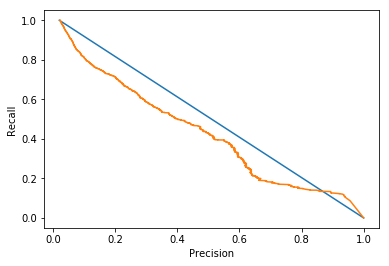

In [228]:
from sklearn.metrics import precision_recall_curve

#f1.5 score rf
random = grid_models[3]
y_base = np.zeros(100945)

y_score=random.predict_proba(X_test)[:,1]
precision, recall, thresholds = precision_recall_curve(y_test, y_score)
# prc_auc = auc(fpr, tpr)
precision_base, recall_base, _ = precision_recall_curve(y_test, y_base)

# Plotting our Baseline..
fig, ax = plt.subplots()
plt.plot(precision_base, recall_base) #baseline model
plt.plot(precision, recall)
# sns.lineplot(fpr_base, tpr_base)
ax.set_xlabel('Precision')
ax.set_ylabel('Recall');
# print(f'Area under curve: {prc_auc}')

In [225]:
feature_importance = pd.DataFrame(list(grid_models[3].best_estimator_.feature_importances_), list(X.columns))
feature_importance_plot = feature_importance.sort_values(by = 0, ascending = False).head(6)
plt.()

,0
MAGNITUDE,0.264061
Year,0.133199
BEGIN_LON,0.104564
BEGIN_LAT,0.099290
Temperature,0.073899
Precipitation,0.070128


In [229]:
# threshold_wanted = 0.38
for i, threshold in enumerate(thresholds):
    if precision[i] > 0.35 and recall[i] > 0.45:
#         print(f'Threshold is {threshold}.')
#         print(f'Precision is {precision[i]}.')
#         print(f'Recall is {recall[i]}.')
        print(precision[i], recall[i], threshold)

# print(precision[68459])
# print(recall[68459])

0.35017701963308656 0.5394149727317799 0.606295191720823
0.3502897617514488 0.5394149727317799 0.6064078236069316
0.350402576489533 0.5394149727317799 0.6066514905711835
0.3501129396579542 0.5379276152702033 0.6070994048078068
0.3502259522272434 0.5379276152702033 0.6071151742725279
0.35033903777849534 0.5379276152702033 0.6072405164437316
0.3504521963824289 0.5379276152702033 0.6073221494307117
0.3505654281098546 0.5379276152702033 0.6073274605866584
0.3507921112188813 0.5379276152702033 0.607418021354603
0.35058214747736094 0.5374318294496777 0.6074632115971308
0.35037204788094467 0.5369360436291523 0.6076434832586622
0.3504854368932039 0.5369360436291523 0.6078048125640622
0.35059889932016836 0.5369360436291523 0.6078645064117107
0.35071243523316065 0.5369360436291523 0.6079658189078264
0.35082604470359574 0.5369360436291523 0.6080889265187269
0.3509397278029812 0.5369360436291523 0.6081581523733103
0.35105348460291735 0.5369360436291523 0.6083834859656441
0.35084306095979245 0.5364

0.43206039076376557 0.4823996033713436 0.6622519345486875
0.43225233229675697 0.4823996033713436 0.6625184969090256
0.43244444444444446 0.4823996033713436 0.6626425486816022
0.43251670378619156 0.4814080317302925 0.6629129480841793
0.4327094474153298 0.4814080317302925 0.6629993728402891
0.4329023629068212 0.4814080317302925 0.663090139593844
0.43309545049063336 0.4814080317302925 0.6631470899300367
0.4332887103971441 0.4814080317302925 0.6632293538132213
0.43348214285714287 0.4814080317302925 0.663251886460418
0.4332291201429209 0.480912245909767 0.6633124992163634
0.4334226988382484 0.480912245909767 0.6638541558650283
0.4336164506034868 0.480912245909767 0.6638939862154719
0.4338103756708408 0.480912245909767 0.6640817998810478
0.43355704697986575 0.48041646008924144 0.6645687559884843
0.43375111906893465 0.48041646008924144 0.6649224630038453
0.43394536497984776 0.48041646008924144 0.6649620698631287
0.43413978494623656 0.48041646008924144 0.6650796287395693
0.4343343792021515 0.48

In [230]:
input = 
x = np.array(input)
state = np.zeros(78)
state[31] = 1
state[-11] = 1
state = np.array([state])
year = datetime.today().year - 1955
month = datetime.today().month
date = np.array([year, month])
x = np.concatenate((date,x), axis = 1)
x = np.concatenate((x, state), axis = 1)

TypeError: list() takes at most 1 argument (5 given)